In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
pip install scikit-learn-extra

In [10]:
pip install pyclustering


# Importing necessary libraries

In [11]:
from sklearn.cluster import Birch
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


# Data preprocessing
The objective is to first broadly understand the data infront of us with regards to statistical properties and features

In [12]:
df = pd.read_csv('marketing_campaign.csv',sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [14]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


From the dataset description, it is evident that the following two columns do not correspond to any significant information for further analysis and therefore, it can be conveniently dropped

In [15]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

# Handling null values
From the above information, it is clear that only the income column has some null values, and since their number is not very high, we can replace them by the median income value

In [16]:
df['Income'] = df['Income'].fillna(df['Income'].median())
df.isnull().sum().sum()

0

# Feature engineering
* A column for age is prepared using the date of birth of each customer
* The food expenditure is combined for meat and fish products to form a non-veg column and the remaining are combined as a different column
* The marital status column is encoded to numerical value
* The number of kids and teens are combined to form the total number of children for a family

In [17]:
df['Age'] = 2022 - df['Year_Birth']
df['Non_Veg_Amt']= df['MntMeatProducts'] + df['MntFishProducts']
df['Others_Amt'] = df['MntWines'] + df['MntSweetProducts'] + df['MntFruits']
df.drop(['MntMeatProducts', 'MntFishProducts', 'MntWines','MntSweetProducts', 'MntFruits'], axis=1, inplace=True)
df.drop('Year_Birth', axis=1, inplace=True)

In [18]:
df['Education'].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [19]:
df['Marital_Status'].value_counts() 

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [20]:
df['Children'] = df['Kidhome']+df['Teenhome']
df['Family_Size'] = df['Children'] + df['Marital_Status'].replace({'Married':2, 'Together':2, 'Single':1, 'Divorced':1, 'Widow':1,
                                                                  'Alone':1, 'Absurd':1,'YOLO':1})
df.drop(['Kidhome','Teenhome'], axis=1, inplace=True)


In [21]:
df['Marital_Status'].replace({'Married':2, 'Together':2, 'Single':1, 'Divorced':1, 'Widow':1,
                                                                  'Alone':1, 'Absurd':1,'YOLO':1}, inplace=True)
df['Marital_Status'].value_counts()

2    1444
1     796
Name: Marital_Status, dtype: int64

# Exploratory data analysis
The objective here is to have a holistic understanding of the customer base in the market through specific queries. Athough, the dataset has several features, it can be understood that certain features like complain, acceptance of ad campaign have a particular significance behind this customer analysis study.

# How many people accepted the offer in each campaign?
Through this question, we can understand how successful each of the ad campaing has been with regards to customer acceptance

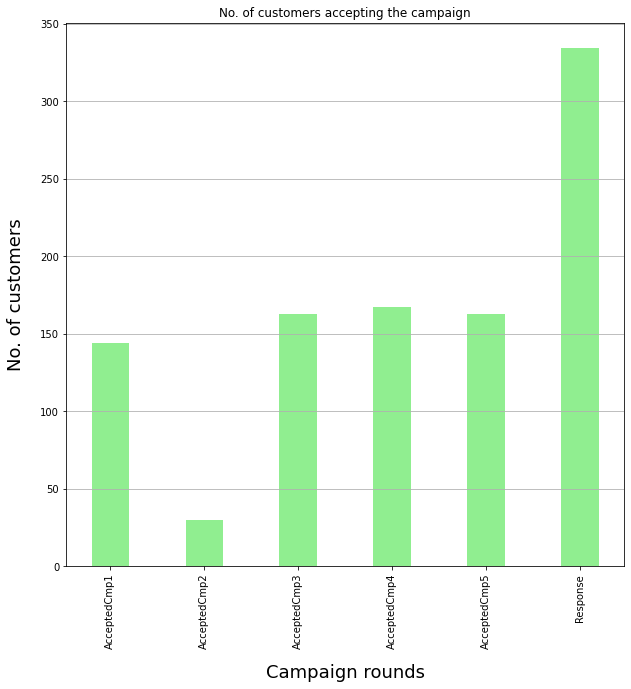

In [53]:
camp_lst = ['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
val_lst = []
for elm in camp_lst:
    cond = df[elm]==1
    val_lst.append(df.loc[cond, elm].count())
    
fig = plt.figure(figsize =(10, 10)) 
plt.bar(camp_lst, val_lst, color ='lightgreen',
        width = 0.4)
plt.grid(zorder = 0, axis = "y")
plt.xlabel("Campaign rounds", fontsize = 18, labelpad=15)
plt.xticks(rotation=90)
plt.ylabel("No. of customers",fontsize = 18, labelpad=15)
plt.title("No. of customers accepting the campaign")

plt.show()

# How many single and married customers accepted the offer in each campaign?

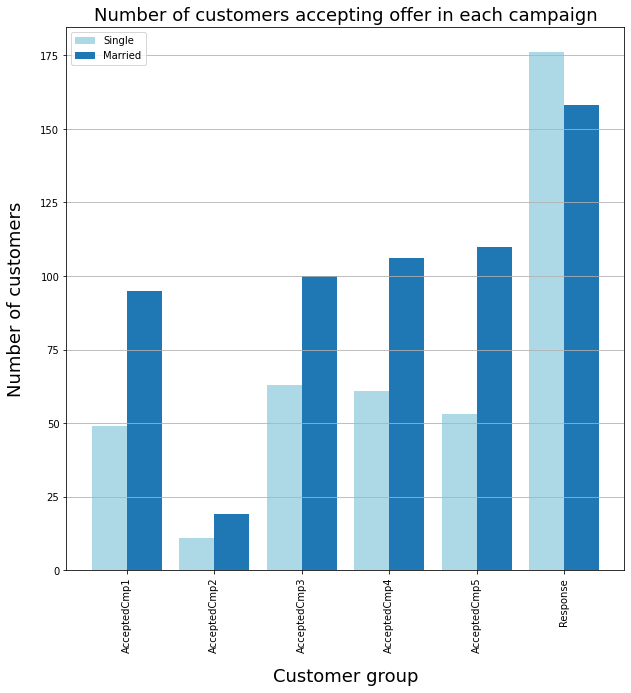

In [23]:
cond1 = df['Marital_Status']==1
cond2 = df['Marital_Status']==2
cond3 = df['AcceptedCmp1'] == 1

df.loc[(cond1) &(cond3)].shape[0]

sing_lst = []
marr_lst = []
c1 = df['Marital_Status']==1
c2 = df['Marital_Status']==2
for elm in camp_lst:
    c3 = df[elm]==1
    sing_lst.append(df.loc[(c1)& (c3)].shape[0])
    marr_lst.append(df.loc[(c2)&(c3)].shape[0])
    
X_axis = np.arange(len(camp_lst)) 
fig = plt.figure(figsize =(10, 10)) 
plt.bar(X_axis - 0.2, sing_lst, 0.4, color = 'lightblue',label = 'Single')
plt.bar(X_axis + 0.2, marr_lst, 0.4, label = 'Married')
plt.grid(zorder = 0, axis = "y")  
plt.xticks(X_axis, camp_lst)
plt.xlabel("Customer group",fontsize = 18, labelpad=15)
plt.ylabel("Number of customers", fontsize = 18, labelpad=15)
plt.title("Number of customers accepting offer in each campaign", fontsize = 18)
plt.xticks(rotation=90)
plt.legend()
plt.show()
    
    

# How many customers who have complained atleast once in last two years have accepted the campaign offer?

In [24]:
df['Complain'].value_counts()

0    2219
1      21
Name: Complain, dtype: int64

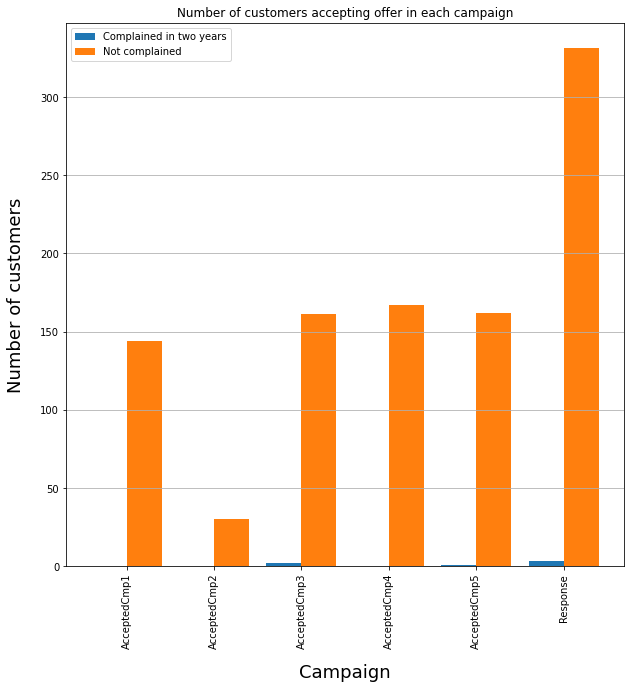

In [25]:
compln_yes = []
compln_no = []
c1 = df['Complain']==1
c2 = df['Complain']==0
for elm in camp_lst:
    c3 = df[elm]==1
    compln_yes.append(df.loc[(c1)& (c3)].shape[0])
    compln_no.append(df.loc[(c2)&(c3)].shape[0])
    
X_axis = np.arange(len(camp_lst)) 
fig = plt.figure(figsize =(10, 10))
plt.bar(X_axis - 0.2, compln_yes, 0.4,label = 'Complained in two years')
plt.bar(X_axis + 0.2, compln_no, 0.4, label = 'Not complained')
plt.grid(zorder = 0, axis = "y")  
plt.xticks(X_axis, camp_lst)
plt.xlabel("Campaign",fontsize = 18, labelpad=15)
plt.ylabel("Number of customers", fontsize = 18, labelpad=15)
plt.title("Number of customers accepting offer in each campaign")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# What is the total expenditure in each food category of customers accepting campaign offer?

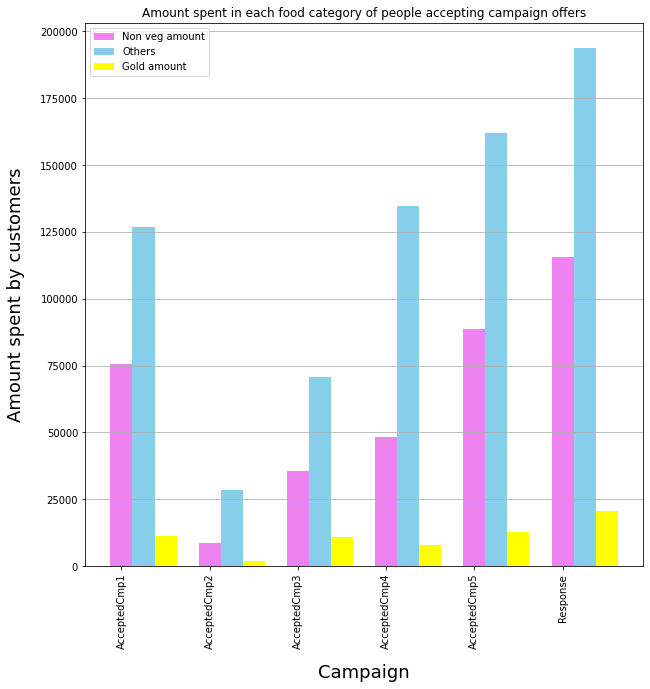

In [26]:
NonVeg = []
Other = []
Gold = []
for elm in camp_lst:
    c1 = df[elm]==1
    NonVeg.append(df[c1]['Non_Veg_Amt'].sum())
    Other.append(df[c1]['Others_Amt'].sum())
    Gold.append(df[c1]['MntGoldProds'].sum())

X_axis = np.arange(len(camp_lst)) 
width = 0.25
fig = plt.figure(figsize =(10, 10))
bar1 = plt.bar(X_axis, NonVeg, width, color = 'violet')
bar2 = plt.bar(X_axis+width, Other, width, color = 'skyblue')
bar3 = plt.bar(X_axis+width*2, Gold, width, color = 'yellow')
plt.xticks(X_axis, camp_lst)
plt.grid(zorder = 0, axis = "y")
plt.xlabel("Campaign", fontsize = 18, labelpad=15)
plt.ylabel("Amount spent by customers", fontsize = 18, labelpad=15)
plt.title("Amount spent in each food category of people accepting campaign offers")
plt.xticks(rotation=90)
plt.legend((bar1,bar2,bar3), ('Non veg amount', "Others", 'Gold amount'))
plt.show()

In [27]:
df[cond]['Education'].value_counts()

Graduation    152
PhD           101
Master         57
2n Cycle       22
Basic           2
Name: Education, dtype: int64

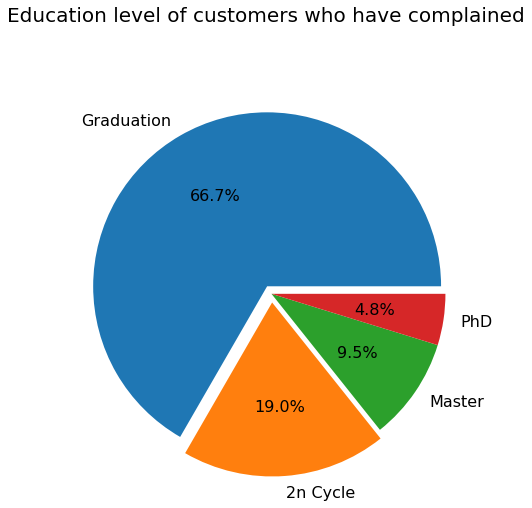

In [28]:
cond = df['Complain']==1
x = df[cond]['Education'].value_counts()
explode = (0.1,0.1,0,0,)
fig, ax = plt.subplots()
labels = 'Graduation', '2n Cycle', 'Master', 'PhD'
ax.pie( x, labels = labels, explode= explode,radius =2, textprops={'fontsize': 16}, autopct='%1.1f%%')
plt.suptitle("Education level of customers who have complained", size =20, y=1.5)
plt.show()

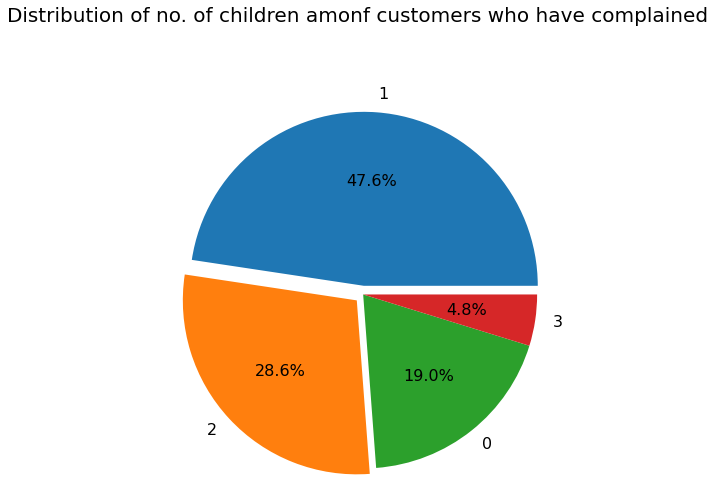

In [29]:
x = df[cond]['Children'].value_counts()
explode = (0.1,0.1,0,0,)
fig, ax = plt.subplots()
labels = '1', '2', '0', '3'
ax.pie( x, labels = labels, explode= explode,radius =2, textprops={'fontsize': 16}, autopct='%1.1f%%')
plt.suptitle("Distribution of no. of children amonf customers who have complained", size =20, y=1.5)
plt.show()

# Customers who have accepted offer in multiple ad campaign

# How many customers who have purchased with deals have accepted the campaign offers?

In [49]:
val = []
c2 = df['NumDealsPurchases'] != 0
for elm in camp_lst:
    cond = df[elm]==1
    val.append(df[cond][c2].shape[0])
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


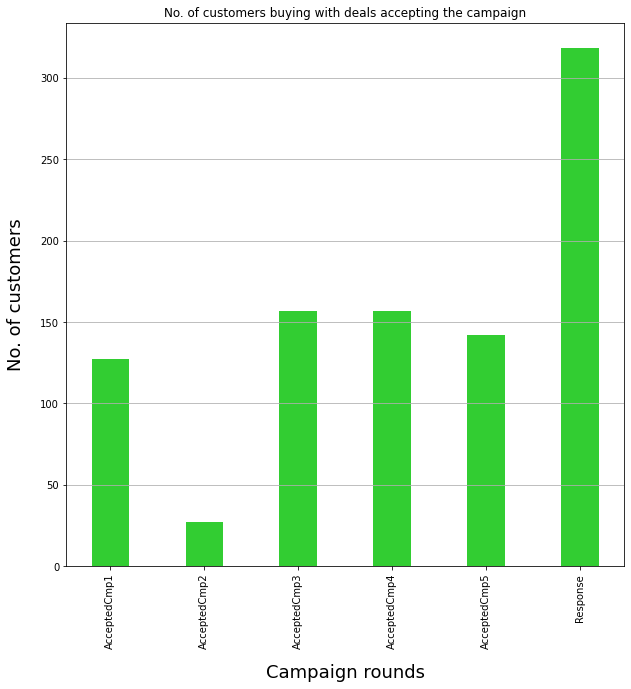

In [50]:
fig = plt.figure(figsize =(10, 10)) 
plt.bar(camp_lst, val, color ='limegreen',
        width = 0.4)
plt.grid(zorder = 0, axis = "y")
plt.xlabel("Campaign rounds", fontsize = 18, labelpad=15)
plt.xticks(rotation=90)
plt.ylabel("No. of customers",fontsize = 18, labelpad=15)
plt.title("No. of customers buying with deals accepting the campaign")

plt.show()

In [51]:
df.drop('Dt_Customer',axis=1, inplace=True)
df.drop('ID', axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Education'])
df.drop('Education_Basic', axis=1, inplace=True)

KeyError: ignored

# Handling outliers
From the boxplot below, it is evident that there are outliers for several numerical features. Since, our dataset is not very large, we replace the outlier values using the interquartile-range method.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


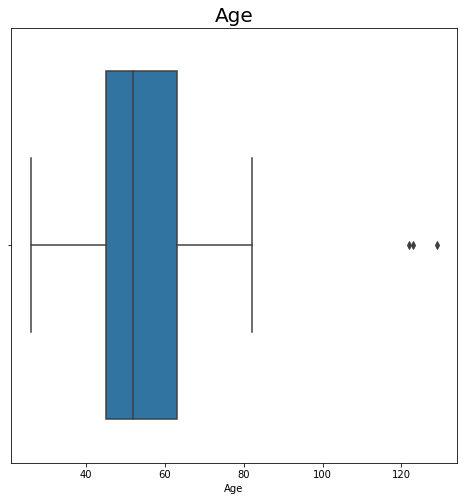

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


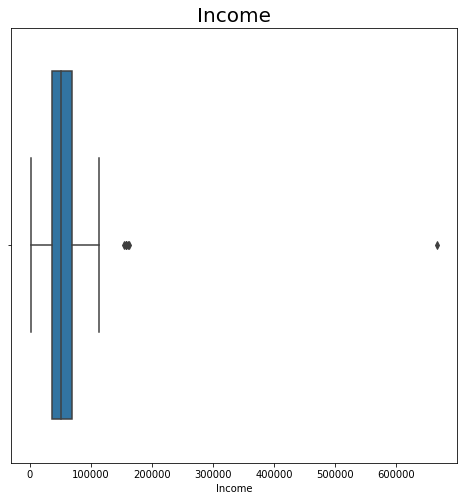

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


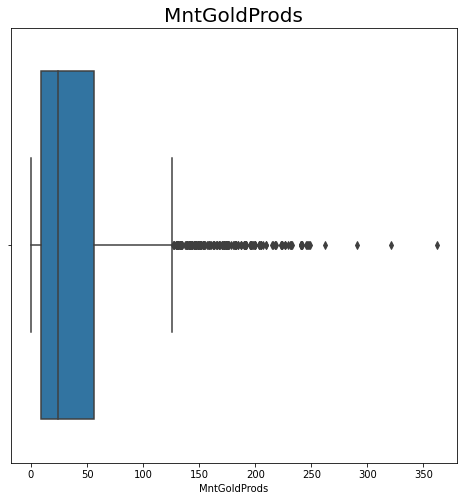

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


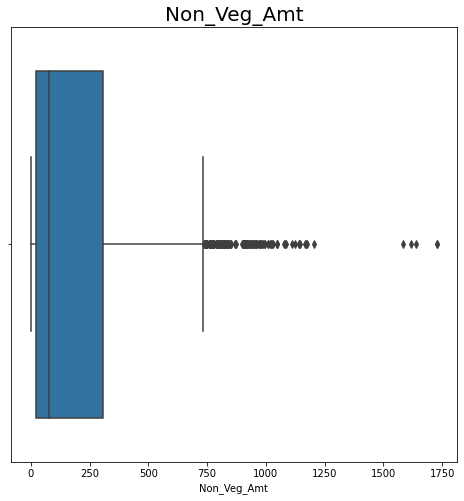

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


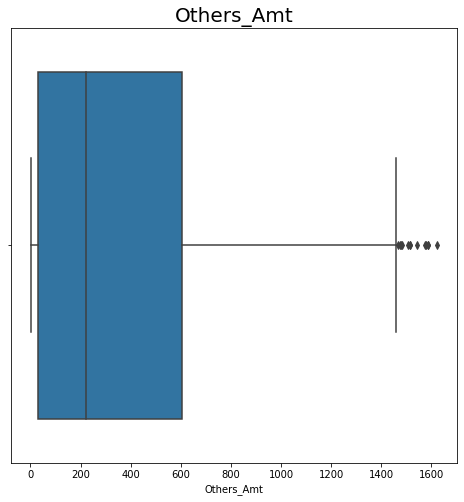

In [33]:
cols = ['Age','Income', 'MntGoldProds', 'Non_Veg_Amt', 'Others_Amt']
for fea in cols:
    plt.figure(figsize=(8,8))
    sns.boxplot(df[fea])
    plt.title(fea, fontsize=20)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


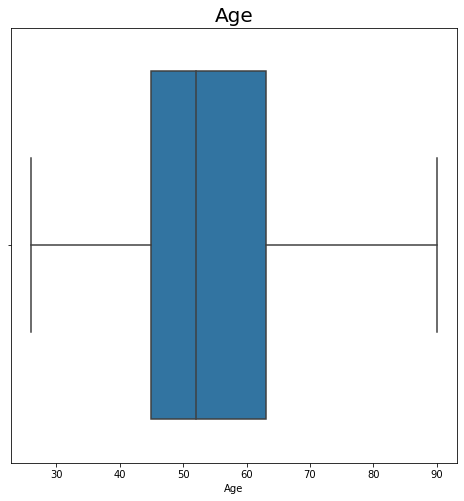

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


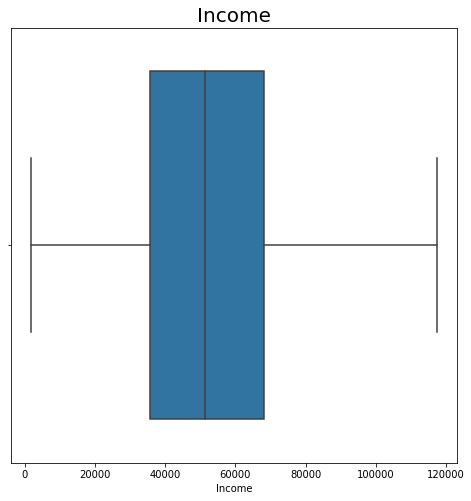

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


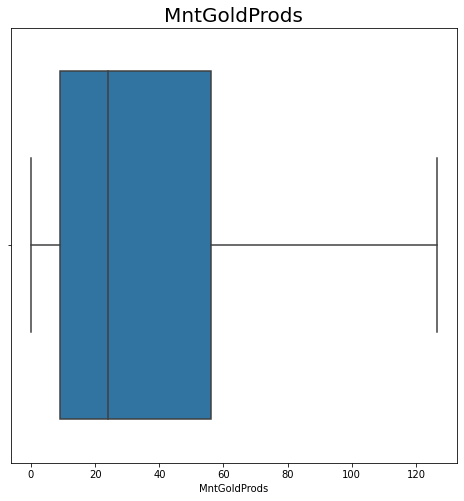

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


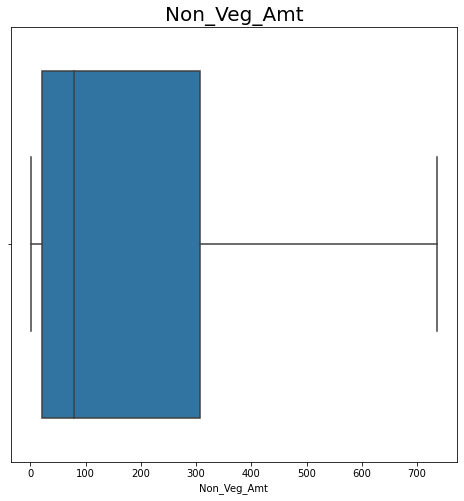

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


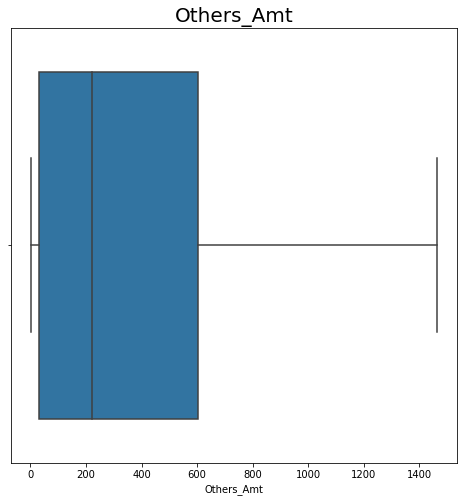

In [34]:
cols = ['Age','Income', 'MntGoldProds', 'Non_Veg_Amt', 'Others_Amt']
for elm in cols:
    q1 = df[elm].quantile(0.25)
    q3 =  df[elm].quantile(0.75)
    iqr = q3 - q1
    up_lim = q3 +1.5*iqr
    low_lim = q1 - 1.5*iqr
    cond = df[elm] > up_lim
    df.loc[cond, elm]= up_lim
    
for fea in cols:
    plt.figure(figsize=(8,8))
    sns.boxplot(df[fea])
    plt.title(fea, fontsize=20)
    plt.show()
    

# Feature scaling
Now that we have done an exhaustive analysis of the data and preprocessing,we can move towards model implementation. However, we also have to do appropriate scaling of our features in order to have better efficiency.

In [35]:
scaler = StandardScaler()
df_sc = scaler.fit_transform(df)

# Model implementation for cluster analysis
* Since the dataset has a large number of features, we intend to apply PCA and perform clustering analysis in two dimension
* Perform elbow method to determine the ideal number of clusters
* We experiment with multiple algorithms to gain a broad overview of the performance


In [36]:
pca = KernelPCA(n_components=2, gamma=0.0433, fit_inverse_transform=True)
reduced= pca.fit_transform(df_sc)
df_pca = pd.DataFrame(reduced)
inv_trns = pca.inverse_transform(reduced)

from sklearn.metrics import mean_squared_error
print('mean_squared_error of original dataset and inverse transformed dataset reduced by kernel PCA {:.2e}'.format(mean_squared_error(df_sc, inv_trns)))

mean_squared_error of original dataset and inverse transformed dataset reduced by kernel PCA 6.80e-01


In [37]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_pca) 
    wcss.append(kmeans.inertia_)

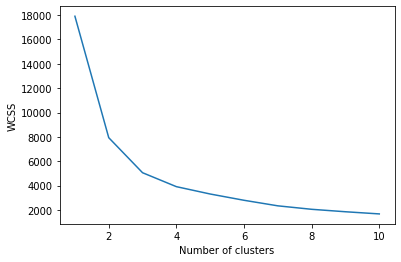

In [38]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

From the above figure, it seems that the optimal number of clusters applicable isthree, but four seems equally plausible. As such we can test our model performace for both three and four clusters

# K-Means

In [39]:
df_dum = df_pca.copy()
for k in range(3,5):
    kmeans = KMeans(n_clusters=k)
    df_dum['Cluster Number',k] = kmeans.fit_predict(df_dum)
    val_coun = df_dum['Cluster Number',k].value_counts()
    print('Cluster distribution with ',k, 'clusters')
    print(val_coun)

Cluster distribution with  3 clusters
1    1076
2     635
0     529
Name: (Cluster Number, 3), dtype: int64
Cluster distribution with  4 clusters
0    708
2    573
1    529
3    430
Name: (Cluster Number, 4), dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


# K-Medoids

In [40]:
df_dum = df_pca.copy()
for k in range(3,5):
    kmeds = KMedoids(n_clusters=k)
    df_dum['Cluster Number',k] = kmeds.fit_predict(df_dum)
    val_coun = df_dum['Cluster Number',k].value_counts()
    print('Cluster distribution with ',k, 'clusters')
    print(val_coun)

Cluster distribution with  3 clusters
1    1033
2     650
0     557
Name: (Cluster Number, 3), dtype: int64
Cluster distribution with  4 clusters
0    613
3    586
1    554
2    487
Name: (Cluster Number, 4), dtype: int64


# BIRCH

In [41]:
df_dum = df_pca.copy()
for k in range(3,5):
    birch = Birch(n_clusters=k)
    df_dum['Cluster Number',k] = birch.fit_predict(df_dum)
    val_coun = df_dum['Cluster Number',k].value_counts()
    print('Cluster distribution with ',k, 'clusters')
    print(val_coun)

Cluster distribution with  3 clusters
2    835
1    791
0    614
Name: (Cluster Number, 3), dtype: int64
Cluster distribution with  4 clusters
2    835
1    640
0    457
3    308
Name: (Cluster Number, 4), dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


# Agglomerative Clustering

In [42]:
df_dum = df_pca.copy()
for k in range(3,5):
    clr = AgglomerativeClustering(n_clusters=k)
    df_dum['Cluster Number',k] = clr.fit_predict(df_dum)
    val_coun = df_dum['Cluster Number',k].value_counts()
    print('Cluster distribution with ',k, 'clusters')
    print(val_coun)


Cluster distribution with  3 clusters
0    1118
1     638
2     484
Name: (Cluster Number, 3), dtype: int64
Cluster distribution with  4 clusters
0    638
3    591
1    527
2    484
Name: (Cluster Number, 4), dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


# Model evaluation
* We consider the silhouette score as the performance metric and attempt to obtain the best combination of hyperparameter values 
* The cluster distribution for a range of models is obtained in a 2D plot

In [43]:
s = []
max_s = 0
max_s_n_clusters = None
affinity = ['euclidean', 'l1','l2', 'cosine','manhattan']
linkage = ['complete','average','single']
best_aff = None
best_l = None
for aff in affinity:
    for l in linkage:
        for i in np.arange(2,8):
            hierarchical_cl = AgglomerativeClustering(n_clusters=i, affinity= aff, linkage = l)
            ypred = hierarchical_cl.fit_predict(reduced)
            sil = silhouette_score(reduced, ypred)
            if sil > max_s:
                max_s = sil
                max_s_n_clusters = np.unique(ypred)
                best_aff = aff
                best_l = l

print('Maximal silhoutte {:.3f}'.format(max_s))
print('Optimal number of clusters', len(max_s_n_clusters))
print('Optimal affinity', best_aff)
print('Optimal linkage', best_l)

Maximal silhoutte 0.498
Optimal number of clusters 2
Optimal affinity euclidean
Optimal linkage single


# Visualization of cluster formation

In [44]:
df_pred = df_pca.copy()

df_pred['Cluster Number (AC)'] = AgglomerativeClustering(n_clusters=4).fit_predict(df_pca)
df_pred['Cluster Number (KM)'] = KMeans(n_clusters=4).fit_predict(df_pca)
df_pred['Cluster Number (KMed)'] = KMedoids(n_clusters = 4).fit_predict(df_pca)
df_pred['Cluster Number (BRC)'] = Birch(n_clusters = 4).fit_predict(df_pca)


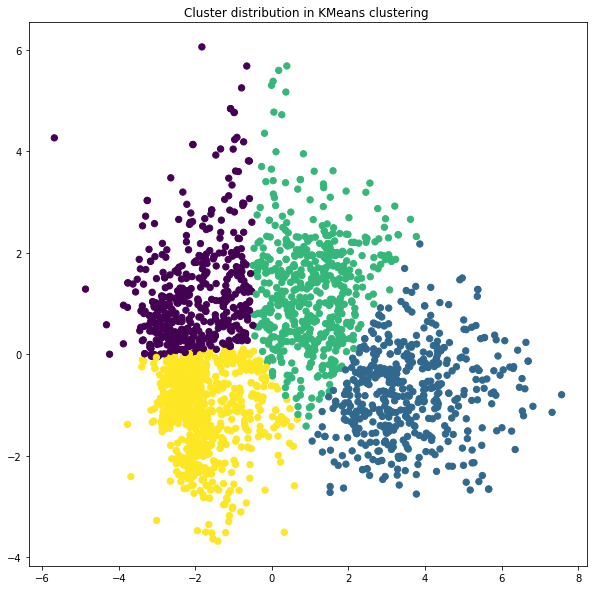

In [45]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, label="bl2")
ax.scatter(x = df_pca[0], y=df_pca[1], s=40,c = df_pred['Cluster Number (KM)'],marker='o' )
ax.set_title("Cluster distribution in KMeans clustering ")
plt.show()

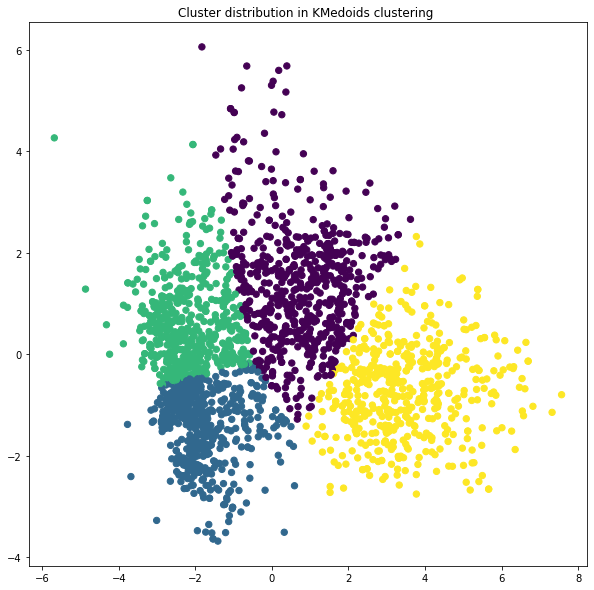

In [46]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, label="bl2")
ax.scatter(x = df_pca[0], y=df_pca[1], s=40,c = df_pred['Cluster Number (KMed)'],marker='o' )
ax.set_title("Cluster distribution in KMedoids clustering ")
plt.show()

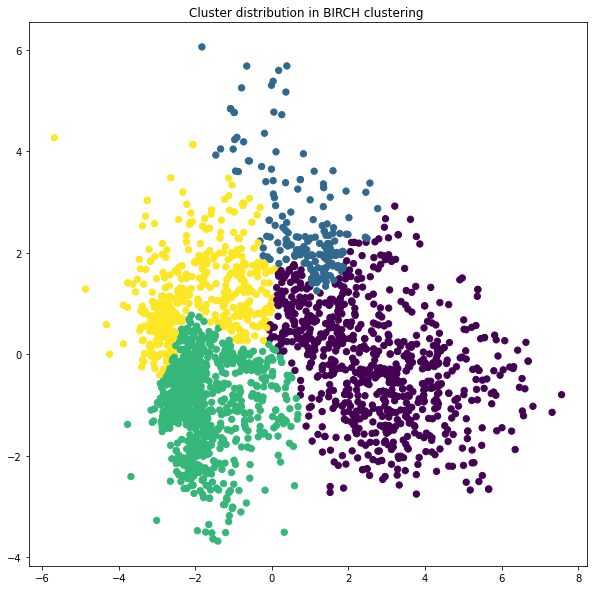

In [47]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, label="bl2")
ax.scatter(x = df_pca[0], y=df_pca[1], s=40,c = df_pred['Cluster Number (BRC)'],marker='o' )
ax.set_title("Cluster distribution in BIRCH clustering ")
plt.show()

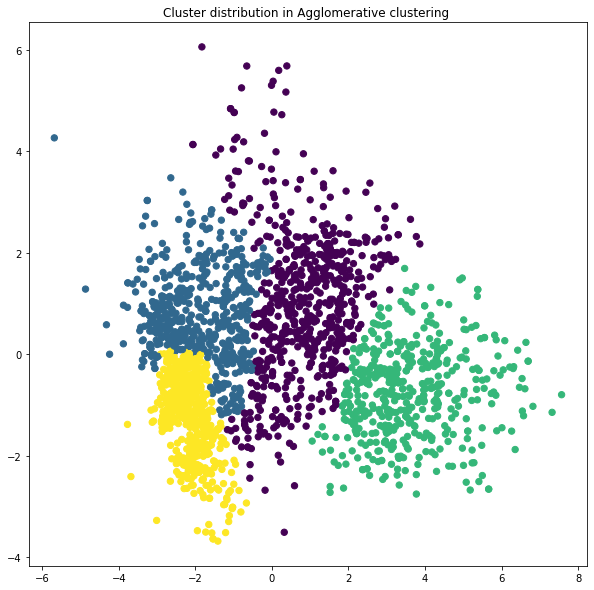

In [48]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, label="bl2")
ax.scatter(x = df_pca[0], y=df_pca[1], s=40,c = df_pred['Cluster Number (AC)'],marker='o' )
ax.set_title("Cluster distribution in Agglomerative clustering ")
plt.show()